In [1]:
!git clone https://github.com/aubinbnf/Speech-Emotion-Recognition.git
%cd Speech-Emotion-Recognition
# !git branch -r
# !git switch TESS
# !git switch simon
# !git status
# !git pull TESS



Cloning into 'Speech-Emotion-Recognition'...
remote: Enumerating objects: 21809, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 21809 (delta 0), reused 3 (delta 0), pack-reused 21801 (from 1)
Receiving objects: 100% (21809/21809), 1.00 GiB | 23.58 MiB/s, done.
Resolving deltas: 100% (434/434), done.
Updating files: 100% (4955/4955), done.
/content/Speech-Emotion-Recognition


In [2]:
%ls
%cd Speech-Emotion-Recognition



 CNN/        CNNBLSTM_ATTENTION/  'data management'/   EXTRAS_MODELS/   PARALELLECNN/         VGG/
 CNNBLSTM/   CNNLSTM_ATTENTION/    dataset/            LSTM/           'Results and plots'/
[Errno 2] No such file or directory: 'Speech-Emotion-Recognition'
/content/Speech-Emotion-Recognition


In [9]:
# Vérification de l'usage du GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("GPU est utilisé")
else:
    print("GPU n'est pas utilisé")


GPU est utilisé


In [10]:
#!/usr/bin/env python3

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import random
import gc

# ==========================
# MEMORY OPTIMIZATION
# ==========================
def clear_memory():
    """Libère la mémoire"""
    gc.collect()
    tf.keras.backend.clear_session()

# ==========================
# DATA GENERATOR
# ==========================
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_list, labels, batch_size=32, dim=(224, 224),
                 n_channels=3, n_classes=7, shuffle=True):
        self.file_list = file_list
        self.labels = labels
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.file_list))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.floor(len(self.file_list) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_files = [self.file_list[k] for k in indexes]
        X, y = self.__data_generation(batch_files, indexes)
        return X, y

    def __data_generation(self, batch_files, indexes):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.n_classes), dtype=int)

        for i, file_name in enumerate(batch_files):
            img = Image.open(file_name).convert("RGB").resize(self.dim)
            img_array = np.array(img) / 255.0

            X[i,] = img_array
            y[i] = self.labels[indexes[i]]

        return X, y

# ==========================
# MODEL CREATION
# ==========================
def create_model(input_shape, num_classes):
    """Crée et retourne le modèle"""
    base_model = VGG19(
        weights='imagenet',
        pooling='avg',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze early layers
    for layer in base_model.layers[:15]:
        layer.trainable = False

    model = Sequential([
        base_model,
        Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

# ==========================
# MAIN TRAINING LOOP
# ==========================
def main():
    # Configuration
    dataset_dir = "/content/Speech-Emotion-Recognition/dataset"
    batch_size = 32
    emotion_map = {
        "angry": 0, "sad": 1, "surprise": 2, "neutral": 3,
        "happy": 4, "fearful": 5, "disgust": 6
    }

    # Préparer les listes de fichiers
    original_files = []
    augmented_files = []
    original_labels = []
    augmented_labels = []

    # Séparer les fichiers originaux et augmentés
    for file_name in os.listdir(dataset_dir):
        if file_name.endswith(".png"):
            full_path = os.path.join(dataset_dir, file_name)
            emotion = file_name.split("_")[1].lower()

            if emotion in emotion_map:
                label = to_categorical(emotion_map[emotion], num_classes=len(emotion_map))

                if '_aug' in file_name:
                    augmented_files.append(full_path)
                    augmented_labels.append(label)
                else:
                    original_files.append(full_path)
                    original_labels.append(label)

    # Diviser les fichiers originaux en train, validation et test
    train_files, temp_files, train_labels, temp_labels = train_test_split(
        original_files, original_labels, test_size=0.35, random_state=42, shuffle=True
    )

    # Diviser les fichiers temporaires en validation et test
    val_files, test_files, val_labels, test_labels = train_test_split(
        temp_files, temp_labels, test_size=0.5, random_state=42, shuffle=True
    )

    # Ajouter les fichiers augmentés UNIQUEMENT à l'ensemble d'entraînement
    train_files.extend(augmented_files)
    train_labels.extend(augmented_labels)

    # Mélanger l'ensemble d'entraînement
    temp = list(zip(train_files, train_labels))
    random.shuffle(temp)
    train_files, train_labels = zip(*temp)
    train_files, train_labels = list(train_files), list(train_labels)

    # Afficher les statistiques du dataset
    print("\nDistribution du Dataset:")
    print(f"Nombre total de fichiers: {len(original_files) + len(augmented_files)}")
    print(f"Ensemble d'entraînement: {len(train_files)} fichiers (dont {len(augmented_files)} augmentés)")
    print(f"Ensemble de validation: {len(val_files)} fichiers")
    print(f"Ensemble de test: {len(test_files)} fichiers")

    # Créer les générateurs
    train_generator = DataGenerator(
        train_files, train_labels, batch_size=batch_size, shuffle=True
    )
    val_generator = DataGenerator(
        val_files, val_labels, batch_size=batch_size, shuffle=False
    )
    test_generator = DataGenerator(
        test_files, test_labels, batch_size=batch_size, shuffle=False
    )

    # Clear memory and create model
    clear_memory()
    model = create_model((224, 224, 3), len(emotion_map))

    # Compile model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )

    # Callbacks
    callbacks = [
        ModelCheckpoint(
            "best_model.keras",
            monitor="val_accuracy",
            save_best_only=True,
            mode="max",
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_accuracy',
            patience=3,
            factor=0.5,
            min_lr=1e-6,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_accuracy',
            patience=8,
            restore_best_weights=True,
            verbose=1
        )
    ]

    # Training
    history = model.fit(
        train_generator,
        epochs=50,
        validation_data=val_generator,
        callbacks=callbacks,
        verbose=1
    )
    return history, model, test_generator, emotion_map,train_files,val_files,test_files,test_labels


# Run the main function and store the returns
history, model, test_generator, emotion_map,train_files,val_files,test_files,test_labels = main()



Distribution du Dataset:
Nombre total de fichiers: 4875
Ensemble d'entraînement: 3874 fichiers (dont 2015 augmentés)
Ensemble de validation: 500 fichiers
Ensemble de test: 501 fichiers
Epoch 1/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.1983 - loss: 7.7155
Epoch 1: val_accuracy improved from -inf to 0.28542, saving model to best_model.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 100s 671ms/step - accuracy: 0.1986 - loss: 7.7124 - val_accuracy: 0.2854 - val_loss: 7.2404 - learning_rate: 1.0000e-04
Epoch 2/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.2966 - loss: 6.4947
Epoch 2: val_accuracy improved from 0.28542 to 0.40833, saving model to best_model.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 83s 658ms/step - accuracy: 0.2969 - loss: 6.4924 - val_accuracy: 0.4083 - val_loss: 5.6545 - learning_rate: 1.0000e-04
Epoch 3/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.4336 - loss: 5.5158
Epoch 3: val_accuracy improved from 0.40833 to 0.42500, saving model to best_m

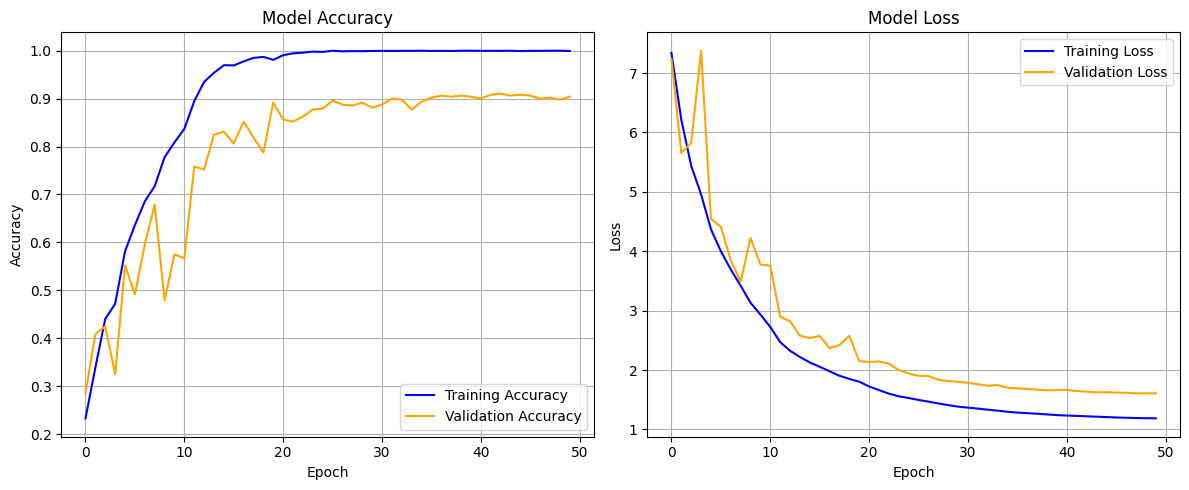


Generating predictions for confusion matrix...


<Figure size 1000x800 with 0 Axes>

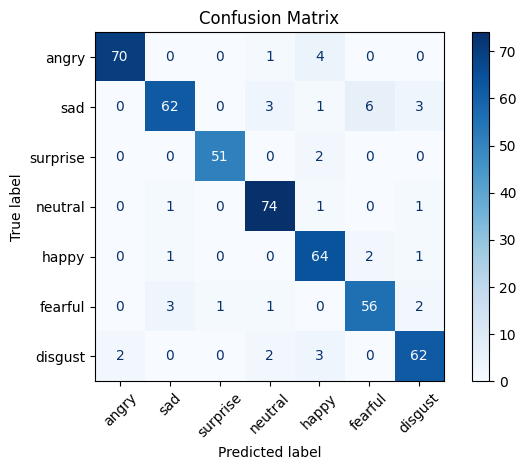


Classification Report:
              precision    recall  f1-score   support

       angry       0.97      0.93      0.95        75
         sad       0.93      0.83      0.87        75
    surprise       0.98      0.96      0.97        53
     neutral       0.91      0.96      0.94        77
       happy       0.85      0.94      0.90        68
     fearful       0.88      0.89      0.88        63
     disgust       0.90      0.90      0.90        69

    accuracy                           0.91       480
   macro avg       0.92      0.92      0.92       480
weighted avg       0.92      0.91      0.91       480



In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def plot_training_curves_and_confusion_matrix(history, model, test_generator, emotion_map):
    """
    Plot training and validation accuracy, loss curves, and confusion matrix.

    Parameters:
    history: keras history object containing training metrics
    model: trained keras model
    test_generator: DataGenerator for test data
    emotion_map: dictionary mapping emotions to indices
    """

    # Accuracy and Loss plots
    plt.figure(figsize=(12, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Get predictions for test set
    test_steps = len(test_generator)
    predictions = []
    true_labels = []

    print("\nGenerating predictions for confusion matrix...")
    for i in range(test_steps):
        x, y = test_generator[i]
        batch_predictions = model.predict(x, verbose=0)
        predictions.extend(batch_predictions)
        true_labels.extend(y)

    # Convert predictions and true labels to class indices
    y_pred = np.argmax(predictions, axis=1)
    y_true = np.argmax(true_labels, axis=1)

    # Calculate and display confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(emotion_map))))
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=list(emotion_map.keys())
    )

    # Plot confusion matrix
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title('Confusion Matrix')

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    # Save and display the plot
    plt.savefig('confusion_matrix.png', bbox_inches='tight')
    plt.show()

    # Print classification report
    from sklearn.metrics import classification_report
    print("\nClassification Report:")
    print(classification_report(
        y_true,
        y_pred,
        target_names=list(emotion_map.keys())
    ))

plot_training_curves_and_confusion_matrix(history, model, test_generator, emotion_map)

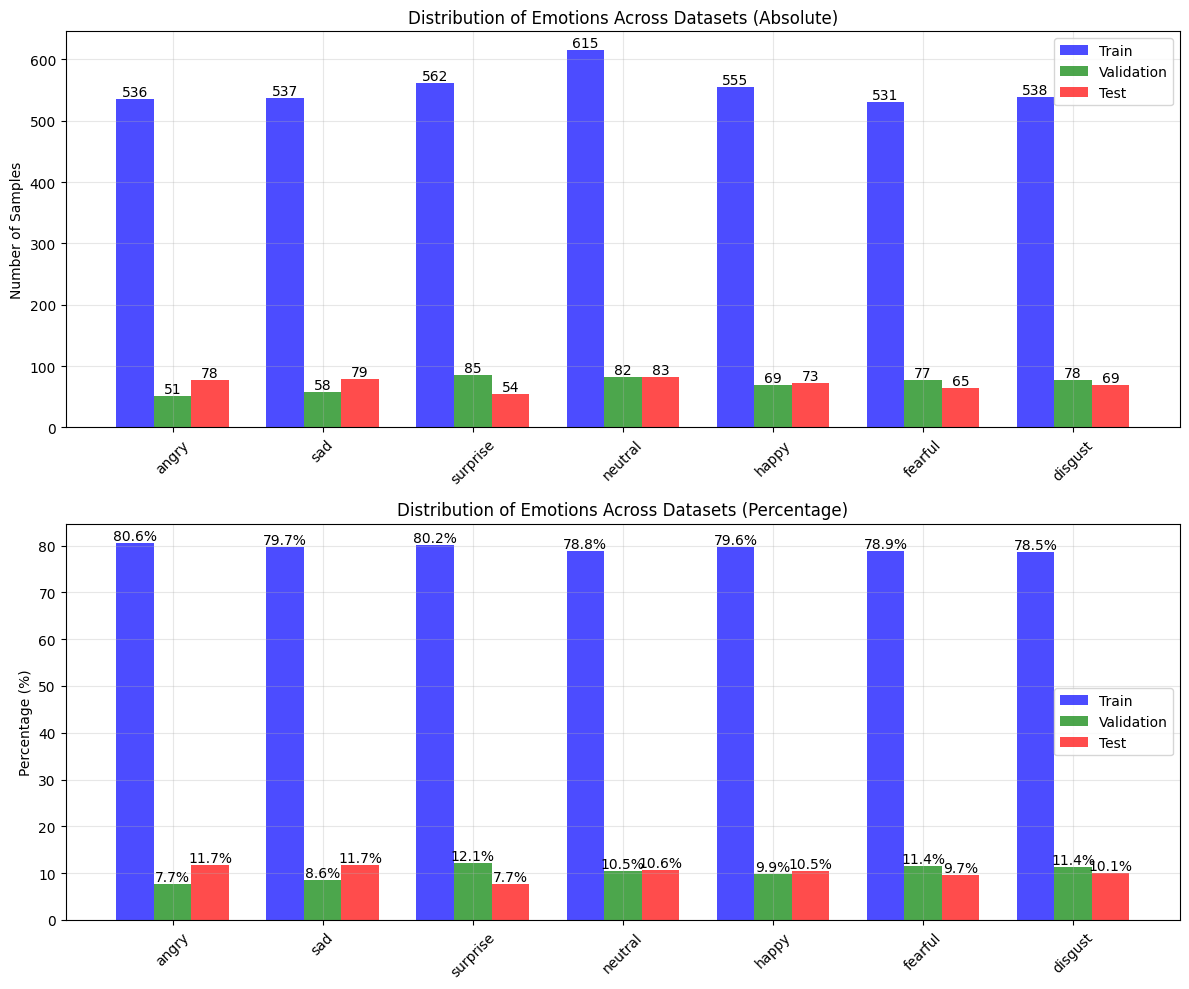


Dataset Distribution Summary:
Total samples: 4875
Training samples: 3874 (79.5%)
Validation samples: 500 (10.3%)
Test samples: 501 (10.3%)


In [12]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def plot_dataset_distribution(train_files, val_files, test_files, emotion_map):
    """
    Plot the distribution of emotions across train, validation and test sets.

    Parameters:
    train_files: list of training file paths
    val_files: list of validation file paths
    test_files: list of test file paths
    emotion_map: dictionary mapping emotions to indices
    """

    def get_emotion_counts(files):
        emotions = []
        for file in files:
            # Extract emotion from filename (assuming format contains "_emotion_")
            emotion = file.split("_")[1].lower()
            emotions.append(emotion)
        return dict(Counter(emotions))

    # Get counts for each set
    train_counts = get_emotion_counts(train_files)
    val_counts = get_emotion_counts(val_files)
    test_counts = get_emotion_counts(test_files)

    # Prepare data for plotting
    emotions = list(emotion_map.keys())
    train_data = [train_counts.get(emotion, 0) for emotion in emotions]
    val_data = [val_counts.get(emotion, 0) for emotion in emotions]
    test_data = [test_counts.get(emotion, 0) for emotion in emotions]

    # Set up the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Bar width and positions
    width = 0.25
    x = np.arange(len(emotions))

    # Plot absolute counts
    ax1.bar(x - width, train_data, width, label='Train', color='blue', alpha=0.7)
    ax1.bar(x, val_data, width, label='Validation', color='green', alpha=0.7)
    ax1.bar(x + width, test_data, width, label='Test', color='red', alpha=0.7)

    ax1.set_ylabel('Number of Samples')
    ax1.set_title('Distribution of Emotions Across Datasets (Absolute)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(emotions, rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Add value labels on the bars
    def add_value_labels(ax, data, offset):
        for i, v in enumerate(data):
            ax.text(i + offset, v, str(v),
                   ha='center', va='bottom')

    add_value_labels(ax1, train_data, -width)
    add_value_labels(ax1, val_data, 0)
    add_value_labels(ax1, test_data, width)

    # Calculate and plot percentages
    total_samples = np.array(train_data) + np.array(val_data) + np.array(test_data)
    train_pct = np.array(train_data) / total_samples * 100
    val_pct = np.array(val_data) / total_samples * 100
    test_pct = np.array(test_data) / total_samples * 100

    ax2.bar(x - width, train_pct, width, label='Train', color='blue', alpha=0.7)
    ax2.bar(x, val_pct, width, label='Validation', color='green', alpha=0.7)
    ax2.bar(x + width, test_pct, width, label='Test', color='red', alpha=0.7)

    ax2.set_ylabel('Percentage (%)')
    ax2.set_title('Distribution of Emotions Across Datasets (Percentage)')
    ax2.set_xticks(x)
    ax2.set_xticklabels(emotions, rotation=45)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Add percentage labels
    def add_percentage_labels(ax, data, offset):
        for i, v in enumerate(data):
            ax.text(i + offset, v, f'{v:.1f}%',
                   ha='center', va='bottom')

    add_percentage_labels(ax2, train_pct, -width)
    add_percentage_labels(ax2, val_pct, 0)
    add_percentage_labels(ax2, test_pct, width)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\nDataset Distribution Summary:")
    print(f"Total samples: {sum(total_samples)}")
    print(f"Training samples: {sum(train_data)} ({sum(train_data)/sum(total_samples)*100:.1f}%)")
    print(f"Validation samples: {sum(val_data)} ({sum(val_data)/sum(total_samples)*100:.1f}%)")
    print(f"Test samples: {sum(test_data)} ({sum(test_data)/sum(total_samples)*100:.1f}%)")

# Dans votre fonction main() ou après la séparation des données
plot_dataset_distribution(train_files, val_files, test_files, emotion_map)

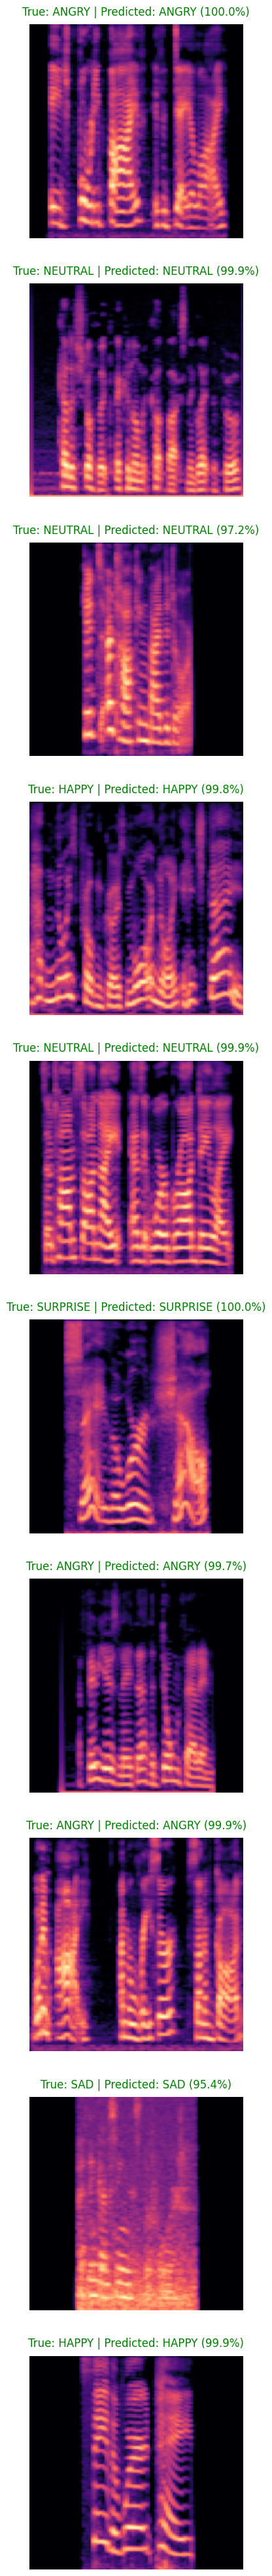


Accuracy on these 10 random samples: 100.0%

Detailed Prediction Probabilities:
------------------------------------------------------------

File: JL_angry_9.png
True emotion: ANGRY
Predictions:
     ANGRY:  100.0%
  SURPRISE:    0.0%
     HAPPY:    0.0%
   DISGUST:    0.0%
   FEARFUL:    0.0%
   NEUTRAL:    0.0%
       SAD:    0.0%
------------------------------------------------------------

File: SAVEE_neutral_216.png
True emotion: NEUTRAL
Predictions:
   NEUTRAL:  100.0%
       SAD:    0.0%
   FEARFUL:    0.0%
     ANGRY:    0.0%
   DISGUST:    0.0%
     HAPPY:    0.0%
  SURPRISE:    0.0%
------------------------------------------------------------

File: TESS_surprise_21.png
True emotion: SURPRISE
Predictions:
  SURPRISE:  100.0%
   FEARFUL:    0.0%
     HAPPY:    0.0%
     ANGRY:    0.0%
       SAD:    0.0%
   NEUTRAL:    0.0%
   DISGUST:    0.0%
------------------------------------------------------------

File: CREMA-D_happy_28.png
True emotion: HAPPY
Predictions:
     HAPPY:

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random

def visualize_test_predictions(test_files, test_labels, model, emotion_map, num_samples=10):
    """
    Visualize spectrograms with true and predicted labels for random test samples.

    Parameters:
    test_files: list of test file paths
    test_labels: list of one-hot encoded true labels
    model: trained model
    emotion_map: dictionary mapping emotions to indices
    num_samples: number of samples to visualize (default=10)
    """

    # Create reverse emotion map for label lookup
    reverse_emotion_map = {v: k for k, v in emotion_map.items()}

    # Randomly select samples
    indices = random.sample(range(len(test_files)), num_samples)

    # Create a figure with num_samples rows and 1 column
    fig = plt.figure(figsize=(12, 4*num_samples))

    for idx, sample_idx in enumerate(indices):
        # Get the image path and true label
        img_path = test_files[sample_idx]
        true_label_idx = np.argmax(test_labels[sample_idx])
        true_emotion = reverse_emotion_map[true_label_idx]

        # Load and preprocess the image
        img = Image.open(img_path).convert("RGB").resize((224, 224))
        img_array = np.array(img) / 255.0

        # Get model prediction
        prediction = model.predict(np.expand_dims(img_array, axis=0), verbose=0)
        pred_label_idx = np.argmax(prediction)
        pred_emotion = reverse_emotion_map[pred_label_idx]
        pred_confidence = prediction[0][pred_label_idx] * 100

        # Create subplot
        ax = plt.subplot(num_samples, 1, idx + 1)

        # Display the spectrogram
        plt.imshow(img_array)
        plt.axis('off')

        # Set title with true and predicted labels
        title_color = 'green' if true_label_idx == pred_label_idx else 'red'
        plt.title(f'True: {true_emotion.upper()} | Predicted: {pred_emotion.upper()} ({pred_confidence:.1f}%)',
                 color=title_color, pad=10)

    plt.tight_layout(pad=3.0)
    plt.show()

    # Print accuracy for these samples
    correct = sum(1 for i in indices if np.argmax(test_labels[i]) ==
                 np.argmax(model.predict(np.expand_dims(np.array(Image.open(test_files[i])
                 .convert("RGB").resize((224, 224))) / 255.0, axis=0), verbose=0)))
    print(f"\nAccuracy on these {num_samples} random samples: {(correct/num_samples)*100:.1f}%")

def print_prediction_probabilities(test_files, test_labels, model, emotion_map, num_samples=10):
    """
    Print detailed prediction probabilities for random test samples.

    Parameters:
    test_files: list of test file paths
    test_labels: list of one-hot encoded true labels
    model: trained model
    emotion_map: dictionary mapping emotions to indices
    num_samples: number of samples to visualize (default=10)
    """
    # Create reverse emotion map for label lookup
    reverse_emotion_map = {v: k for k, v in emotion_map.items()}

    # Randomly select samples
    indices = random.sample(range(len(test_files)), num_samples)

    print("\nDetailed Prediction Probabilities:")
    print("-" * 60)

    for sample_idx in indices:
        # Get the image path and true label
        img_path = test_files[sample_idx]
        true_label_idx = np.argmax(test_labels[sample_idx])
        true_emotion = reverse_emotion_map[true_label_idx]

        # Load and preprocess the image
        img = Image.open(img_path).convert("RGB").resize((224, 224))
        img_array = np.array(img) / 255.0

        # Get model prediction
        prediction = model.predict(np.expand_dims(img_array, axis=0), verbose=0)[0]

        print(f"\nFile: {img_path.split('/')[-1]}")
        print(f"True emotion: {true_emotion.upper()}")
        print("Predictions:")

        # Sort predictions by probability
        sorted_preds = sorted([(reverse_emotion_map[i], prob)
                             for i, prob in enumerate(prediction)],
                            key=lambda x: x[1], reverse=True)

        for emotion, prob in sorted_preds:
            print(f"{emotion.upper():>10}: {prob*100:>6.1f}%")
        print("-" * 60)

# Visualiser les spectrogrammes et les prédictions
visualize_test_predictions(test_files, test_labels, model, emotion_map)

# Afficher les probabilités détaillées
print_prediction_probabilities(test_files, test_labels, model, emotion_map)

In [17]:
# Save final model
model.save('final_model.keras')